![Kickstarer](./images/kickstarter.png)

---
Imports
---

In [1]:
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, train_test_split

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_score, f1_score, confusion_matrix

import time
import json
from functions_kickstarter import *

import warnings
warnings.filterwarnings('ignore')

RSEED = 42069

In [2]:
# Import the .csv files and concat them into one dataframe
original_dataframe = pd.concat(map(pd.read_csv, glob.glob('data/data-2/*.csv')))
# Reset the indices
original_dataframe.reset_index(drop=True, inplace=True)

In [3]:
# Set a working dataframe, so that we don't have to wait 10s it to import again if we want to start fresh
df = original_dataframe

---
EDA - Part 1
---

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209222 entries, 0 to 209221
Data columns (total 37 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   backers_count             209222 non-null  int64  
 1   blurb                     209214 non-null  object 
 2   category                  209222 non-null  object 
 3   converted_pledged_amount  209222 non-null  int64  
 4   country                   209222 non-null  object 
 5   created_at                209222 non-null  int64  
 6   creator                   209222 non-null  object 
 7   currency                  209222 non-null  object 
 8   currency_symbol           209222 non-null  object 
 9   currency_trailing_code    209222 non-null  bool   
 10  current_currency          209222 non-null  object 
 11  deadline                  209222 non-null  int64  
 12  disable_communication     209222 non-null  bool   
 13  friends                   300 non-null     o

In [5]:
df.isnull().sum()

backers_count                    0
blurb                            8
category                         0
converted_pledged_amount         0
country                          0
created_at                       0
creator                          0
currency                         0
currency_symbol                  0
currency_trailing_code           0
current_currency                 0
deadline                         0
disable_communication            0
friends                     208922
fx_rate                          0
goal                             0
id                               0
is_backing                  208922
is_starrable                     0
is_starred                  208922
launched_at                      0
location                       226
name                             0
permissions                 208922
photo                            0
pledged                          0
profile                          0
slug                             0
source_url          

In [6]:
# Only a very limited amount of suspended projects (drop), canceled projects will be treated as though they failed
df['state'].value_counts()

successful    117465
failed         75199
canceled        8624
live            7311
suspended        623
Name: state, dtype: int64

In [7]:
# Check for duplicate projects and store them in a table
dups = df.groupby(df.id.tolist()).size().reset_index().rename(columns={0:'count'})
# Sum the final col of that table, and subtract the number of culprits:
dups['count'].sum() - dups.shape[0]

26958

---
Data Cleaning
---

In [8]:
# Drop features which will not be needed for further analysis
dropped_features = ['blurb', 'currency_symbol', 'backers_count', 'is_backing', 'permissions', 'is_starred', 'source_url',
                    'slug', 'name', 'profile', 'friends', 'spotlight', 'is_starrable', 'photo', 'pledged', 'usd_type',
                    'fx_rate', 'location', 'creator', 'currency_trailing_code','current_currency', 'created_at', 'urls', 'disable_communication', 'usd_pledged' ]
df = df.drop(dropped_features, axis=1)

In [9]:
# Sort dataframe by 'date_changed_at' so that we will keep the entry that was most recently updated
df.sort_values('state_changed_at')
# Remove duplicates
duplicates = df.duplicated(subset='id', keep='last')
df = df[~duplicates]

---
Feature Engineering
---

In [10]:
# Extract category from category column
df['category'] = df['category'].apply(lambda x: json.loads(x)['slug'])
df['category'] = df['category'].apply(lambda x: x.split('/',)[0])

In [11]:
# Generate new column with readable timeformat
df['launched_at_new'] = pd.to_datetime(df['launched_at'], unit='s')
df['deadline_new'] = pd.to_datetime(df['deadline'], unit='s')
df['state_changed_at_new'] = pd.to_datetime(df['state_changed_at'], unit='s')

In [12]:
# Create new feature 'duration' that displays wheather the project timespan was more or less than 30 days
df = df.eval('duration = deadline - launched_at')
df['duration'] = ['over' if x > 2592000 else 'under' for x in df['duration']]

In [13]:
# Add new column 'time' that displays the time from project launch to project end
df.eval('time = state_changed_at_new - launched_at_new', inplace=True)
# Convert to days
df['time'] = df['time'].apply(lambda x: pd.Timedelta(x).days)

In [14]:
times_lst = ['launched_at', 'deadline', 'state_changed_at']
change_time(df, times_lst)

,category,converted_pledged_amount,country,currency,deadline,goal,id,launched_at,staff_pick,state,state_changed_at,static_usd_rate,launched_at_new,deadline_new,state_changed_at_new,duration,time
1,games,1950,US,USD,0,1000.0,928751314,0,False,successful,0,1.000000,2017-08-10 17:00:59,2017-09-09 17:00:59,2017-09-09 17:00:59,under,30
2,music,22404,US,USD,0,15000.0,928014092,0,False,successful,0,1.000000,2013-05-13 05:03:15,2013-06-12 05:03:15,2013-06-12 05:03:15,under,30
3,games,165,GB,GBP,0,10000.0,596091328,0,False,failed,0,1.216066,2017-01-12 18:22:56,2017-03-13 17:22:56,2017-03-13 17:22:56,over,59
4,publishing,2820,US,USD,0,2800.0,998516049,0,False,successful,0,1.000000,2012-12-10 20:32:07,2013-01-09 20:32:07,2013-01-09 20:32:07,under,30
5,music,3725,US,USD,0,3500.0,1224600291,0,False,successful,0,1.000000,2015-04-02 02:25:46,2015-05-02 02:25:46,2015-05-02 02:25:46,under,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209217,games,8924,US,USD,0,1500.0,1011591139,0,False,successful,0,1.000000,2018-11-27 22:38:32,2018-12-12 04:45:00,2018-12-12 04:45:01,under,14
209218,music,5710,NL,EUR,0,5000.0,4607750,1,False,successful,0,1.093300,2017-05-14 17:21:54,2017-06-19 22:00:00,2017-06-19 22:00:00,over,36
209219,technology,2681,US,USD,0,2500.0,67097337,0,False,successful,0,1.000000,2012-08-14 20:36:30,2012-09-17 03:59:00,2012-09-17 03:59:01,over,33
209220,film & video,5692,US,USD,0,5500.0,1031742546,0,False,successful,0,1.000000,2015-03-21 13:26:15,2015-04-20 13:26:15,2015-04-20 13:26:19,under,30


In [15]:
df.eval('goal = goal * static_usd_rate', inplace=True)

In [16]:
df.drop('static_usd_rate', axis = 1, inplace=True)

---
EDA - Part 2
---

##### Plots

In [17]:
# Which data needs to be plotted categorical and which numerical
categorical = ['country','currency', 'staff_pick', 'category','duration']
numerical = ['usd_pledged', 'goal', 'converted_pledged_amount']

##### Categorical Data

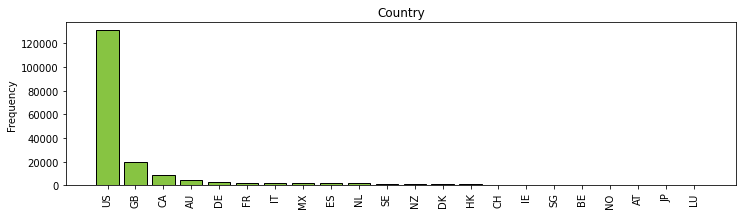

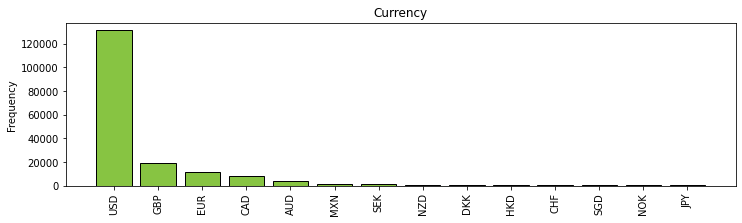

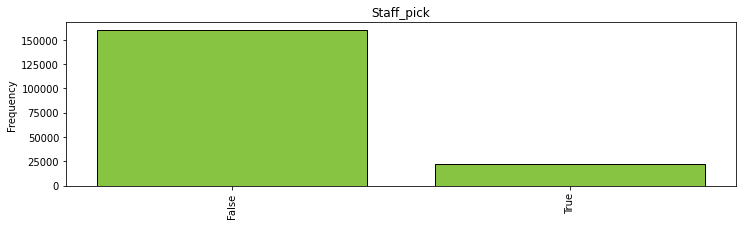

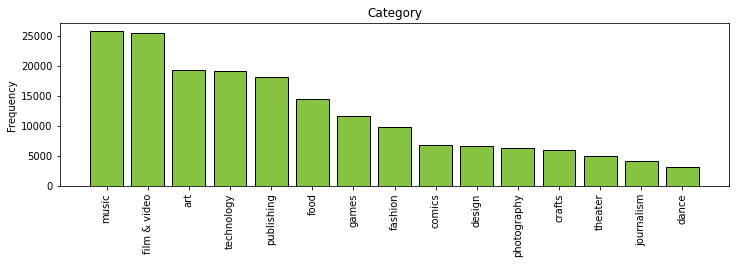

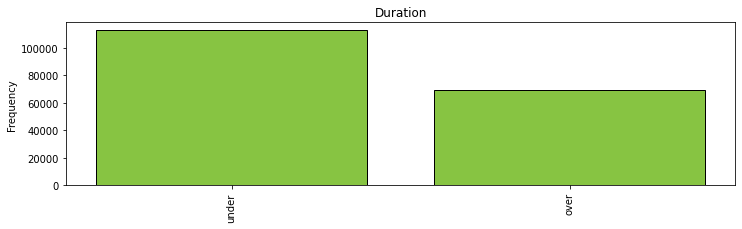

In [18]:
bar_plot(df, categorical)

##### Numerical Data

In [19]:
# We have some values in goal which are unrealistically high
df = df.query('goal < 1000000')

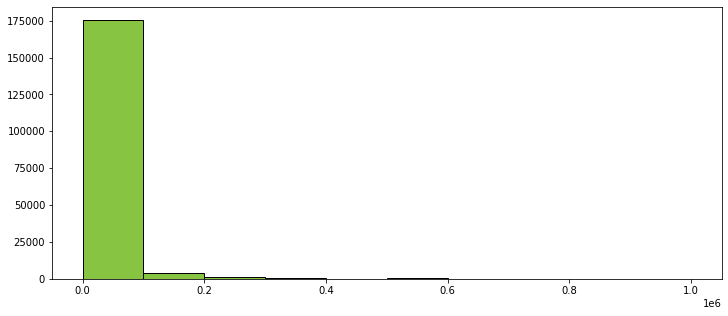

In [20]:
plt.figure(figsize = (12,5))
plt.hist(df['goal'], bins = None, facecolor = '#87c442', edgecolor = 'black');

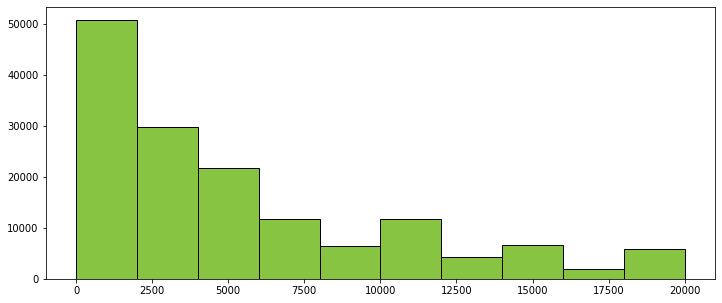

In [21]:
plt.figure(figsize = (12,5))
plt.hist(df['goal'], bins = None, facecolor = '#87c442', edgecolor = 'black', range = [0, 20000]);

##### Misc

In [22]:
# Drop id (not needed anymore) and converted pledged amount
df.drop('id', axis = 1, inplace = True)
df.drop('converted_pledged_amount', axis = 1, inplace = True)

#### One-hot encoding

In [24]:
# One hot encode all categorical data (country, currency, staff_pick, categories, duration) boolean values might 
# Replace True False with strings, otherwise one-hot encoding doesnt work
df['staff_pick'].replace([True,False],['t','f'], inplace=True)

one_hot_featurelist = ['country', 'currency', 'staff_pick', 'category', 'duration']
one_hot = pd.get_dummies(df[one_hot_featurelist])
df.drop(one_hot_featurelist, axis = 1, inplace=True)
df = df.join(one_hot)

#### Scalerize

In [25]:
# Standardize numerical data according to a min-max scaler
numerical = ['goal']
df = scale_columns(df, numerical)

#### Feature Engineering 2

In [26]:
# Drop features which will not be needed for further analysis
dropped_features = ['launched_at_new','deadline_new','state_changed_at_new']
df = df.drop(dropped_features, axis=1)

In [27]:
# Extract live values
array_live = ['live']
live_projects = df.loc[df['state'].isin(array_live)]

# Filter and concat. for target variable
array_notlive = ['successful', 'failed', 'canceled']

df = df.loc[df['state'].isin(array_notlive)]
# Add canceled to failed projects
df.replace('canceled','failed', inplace=True)
# Replace successful and failed entries with 0 and 1
df.replace(['successful','failed'],[1,0], inplace=True)

#### Dummy Classifier and Baseline Model

In [28]:
# Set x and y
X = df.drop('state', axis = 1)
y = df['state']

In [29]:
dummy = DummyClassifier(strategy='stratified', random_state=RSEED, constant=None)
dummy.fit(X,y)

y_pred = dummy.predict(X)
precision_score(y, y_pred)

0.5353712158756604

In [30]:
confusion_matrix(y, y_pred)

array([[38111, 44064],
       [43993, 50773]])

#### Train Model

In [31]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.3, random_state=RSEED)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((123858, 60), (53083, 60), (123858,), (53083,))

In [32]:
# List of models used
models = list()

models.append(LogisticRegression())
models.append(DecisionTreeClassifier())
models.append(RandomForestClassifier())
models.append(GradientBoostingClassifier())
models.append(AdaBoostClassifier(DecisionTreeClassifier(),learning_rate=0.1))
models.append(KNeighborsClassifier())
models.append(XGBClassifier())

In [33]:
# Amount of volding for cross-validation
kfold = StratifiedKFold(n_splits=5)

In [ ]:
# Find cross validation scores from list of models. The target is f1. Time is also accounted for to find the most effective models
cv_results = []
cv_names = []
cv_times = []

for model in models:
    start_time = time.time()
    print('go:', model)
    cv_results.append(cross_val_score(model, X_train, y = y_train, scoring = "precision", cv = kfold, n_jobs=4, verbose=0))
    cv_names.append(model.__class__.__name__)
    end_time = time.time()
    total_time = round(end_time - start_time ,2)
    cv_times.append(total_time)
    print('end:', model)

cv_means = []
cv_std = []

for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":cv_names, "Time needed for training":cv_times})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res,orient = "h",**{'xerr':cv_std})
g.set_xlabel("Average precision")
g = g.set_title("K-fold Cross validation average precision")

In [ ]:
cv_res['criterion'] = cv_res.CrossValMeans - cv_res.CrossValerrors/2
cv_res.sort_values(by='criterion', ascending=False)
# We select XGBClassifier, LogisticRegression, and RandomForestClassifier for hyperparameter tuning

In [ ]:
### XGB classifier

XGB = XGBClassifier()

max_depth = [1,2,4,8,10]
min_child_weight = np.linspace(1, 10, 5, endpoint=True) 

gamma = np.linspace(0.5, 5, 5, endpoint=True)
subsample = np.linspace(0.5, 1, 5, endpoint=True)
colsample_bytree = np.linspace(0.5, 1, 5, endpoint=True)

XGB_param_grid = {
        'min_child_weight': min_child_weight,
        'gamma': gamma,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'max_depth': max_depth
        }


gsXGB = HalvingGridSearchCV(estimator = XGB, 
                    param_grid = XGB_param_grid, cv=kfold, scoring="precision", n_jobs= 4, verbose = 1)

gsXGB.fit(X_train,y_train)

XGB_best = gsXGB.best_estimator_
print(XGB_best.get_params())

# Best score
gsXGB.best_score_

In [ ]:
feature_important = XGB_best.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(120, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

In [ ]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 800, num = 2)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 20, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [ 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [ 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

## Search grid for optimal parameters
rf_param_grid = {"max_depth": max_depth,
              "max_features": max_features,
              "min_samples_split": min_samples_split,
              "min_samples_leaf": min_samples_leaf,
              "bootstrap": bootstrap,
              "n_estimators" :n_estimators,
              "criterion": ["gini"]}
              

gsRFC = HalvingGridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="precision", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,y_train)

RFC_best = gsRFC.best_estimator_

print(RFC_best.get_params())


# Best score
gsRFC.best_score_

In [ ]:
# Logistic Regression Parameters tunning
LR = LogisticRegression( )

# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(-2, 2, 20)

lr_param_grid = {'penalty': penalty, 'C': C }

clf = GridSearchCV(LogisticRegression(), lr_param_grid)

gsLR = GridSearchCV(LR, param_grid = lr_param_grid, cv=kfold, scoring="precision", n_jobs= 4, verbose = -1)

gsLR.fit(X_train,y_train)

LR_best = gsLR.best_estimator_

# View best hyperparameters
print('Best Penalty:', LR_best.get_params()['penalty'])
print('Best C:', LR_best.get_params()['C'])

# Best score
gsLR.best_score_

In [ ]:
# Voting Classifier (soft voting) including the three best models after grid search
votingC = VotingClassifier(estimators=[('LR', LR_best), ('XGB',XGB_best), ("RandomForest",RFC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, y_train)

In [ ]:
votingC_predict = votingC.predict(X_test)
f1_score_votingC = f1_score(votingC_predict, y_test)
f1_score_votingC
# We achieve a max. f1 score of 75.6%

#### Make Predictions on live dataset

In [ ]:
# Set x and y
X_array_live = array_live.drop('state', axis = 1)


In [ ]:
live_projects = votingC.predict(X_array_live)
live_projects.replace([1,0],['successful','failed'], inplace=True)